In [71]:
import gpxpy
import gpxpy.gpx
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from folium.vector_layers import Rectangle
from shapely.geometry import LineString
from shapely.ops import unary_union
from shapely.geometry import Point
import pandas as pd
from math import exp, sqrt, pi
import networkx as nx
from shapely.geometry import LineString, Point
from geopy.distance import geodesic, great_circle

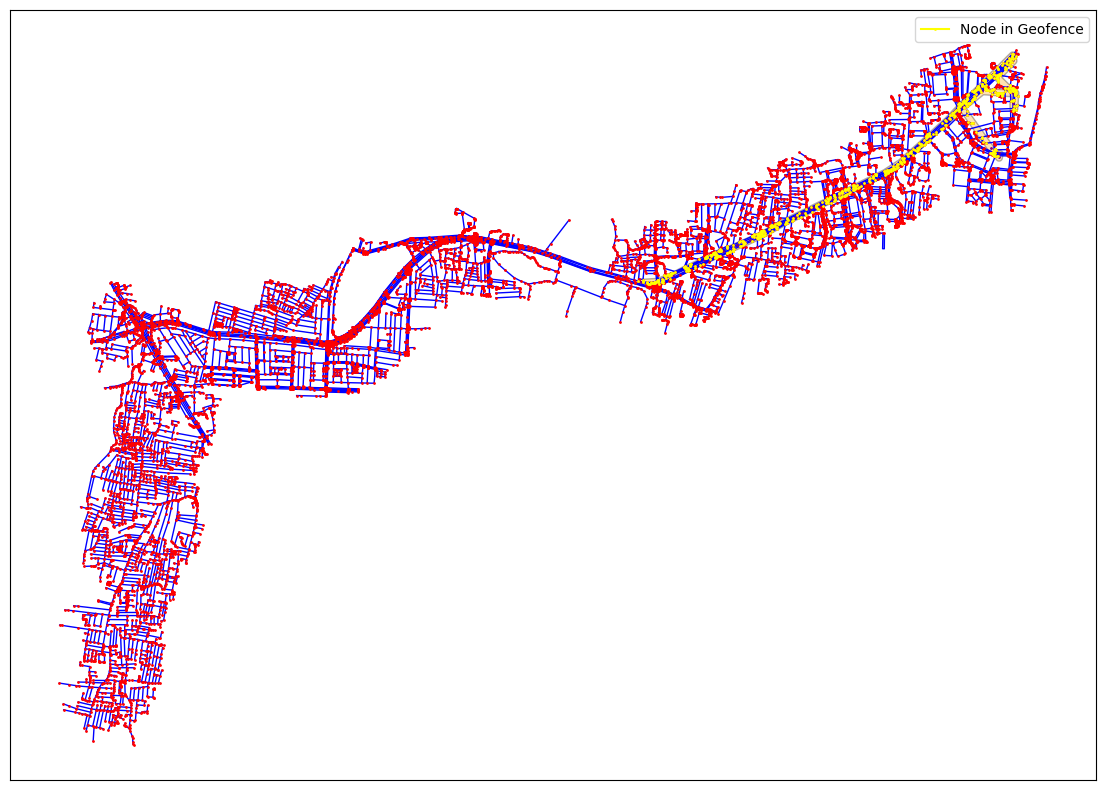

691
[(77.6678594, 12.9220808), (77.6678408, 12.9221258), (77.6678499, 12.9222046), (77.6761182, 12.9256058), (77.6761658, 12.9257883), (77.6695417, 12.9230009), (77.6718021, 12.9239392), (77.6850508, 12.9302866), (77.6742636, 12.9246653), (77.6723413, 12.9238228), (77.6718436, 12.9235862), (77.6717529, 12.9235469), (77.6715654, 12.9234656), (77.6714361, 12.9234096), (77.671252, 12.9233267), (77.6707072, 12.9230752), (77.6706148, 12.9230325), (77.6704041, 12.922928), (77.6693352, 12.9224217), (77.6690825, 12.9223039), (77.6686777, 12.9221153), (77.6932715, 12.9314364), (77.6933405, 12.9314134), (77.6934113, 12.9313985), (77.6935022, 12.9313927), (77.6949726, 12.9356698), (77.6950903, 12.9356672), (77.6945604, 12.9366438), (77.6947093, 12.9366216), (77.6949028, 12.9365927), (77.6949346, 12.9365879), (77.6949947, 12.9365654), (77.6950437, 12.9365362), (77.6950787, 12.9365021), (77.6951008, 12.9364585), (77.6951093, 12.9363978), (77.6951043, 12.9361501), (77.6951025, 12.9360635), (77.69510

In [72]:
fp = "/Users/ashwin/Desktop/IIIT/OSM version - within 500m of the path/For_Route_g1_i79_500m.shp"
data = gpd.read_file(fp)

G = nx.Graph()

for line in data.geometry:
    if line.geom_type == 'LineString':
        start, end = Point(line.coords[0]), Point(line.coords[-1])
        length = line.length
        G.add_node(tuple(start.coords[0]), pos=tuple(start.coords[0]))
        G.add_node(tuple(end.coords[0]), pos=tuple(end.coords[0]))
        G.add_edge(tuple(start.coords[0]), tuple(end.coords[0]), geometry=line)

gpx_file_path = '/Users/ashwin/Desktop/IIIT/fefa3de2-c689-4017-a629-baf7e68f5d69_493.gpx'
with open(gpx_file_path, 'r') as gpx_file:
    gpx = gpxpy.parse(gpx_file)

start_index_3 = 219
end_index_3 = 268
observations_3 = []

for track in gpx.tracks:
    for segment in track.segments:
        for i, point in enumerate(segment.points):
            if start_index_3 <= i < end_index_3:
                observations_3.append((point.longitude, point.latitude))

observations_3_no_duplicates = []
for i, point in enumerate(observations_3):
    if i == 0 or point != observations_3[i - 1]:
        observations_3_no_duplicates.append(point)

gpx_path = LineString(observations_3_no_duplicates)
gpx_gdf = gpd.GeoDataFrame(geometry=[gpx_path], crs="EPSG:4326")
gpx_gdf = gpx_gdf.to_crs(epsg=3857)

geofence = gpx_gdf.buffer(30)
geofence = geofence.to_crs(epsg=4326)

connected_components = sorted(nx.connected_components(G), key=len, reverse=True)

if len(connected_components) > 0:
    subgraph_3 = G.subgraph(connected_components[0]).copy()
    pos_3 = nx.get_node_attributes(subgraph_3, 'pos')

    states_in_geofence_3 = []
    for node, position in pos_3.items():
        point = Point(position)
        if geofence.geometry[0].contains(point):
            states_in_geofence_3.append(position)

    fig, ax = plt.subplots(figsize=(20, 10))

    for edge in subgraph_3.edges(data=True):
        line = edge[2]['geometry']
        x, y = line.xy
        ax.plot(x, y, color='blue', linewidth=1)

    nx.draw_networkx_nodes(subgraph_3, pos_3, ax=ax, node_size=1, node_color='red')

    for point in observations_3_no_duplicates:
        ax.plot(point[0], point[1], marker='o', color='purple', markersize=1)

    geofence.plot(ax=ax, color='orange', alpha=0.3, edgecolor='black')

    for node in states_in_geofence_3:
        ax.plot(node[0], node[1], marker='o', color='yellow', markersize=1, label="Node in Geofence")

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:1], labels[:1])

    plt.show()
    print(len(states_in_geofence_3))
    print(states_in_geofence_3)

def calculate_geodesic_distance(points):
    total_distance = 0.0
    for i in range(1, len(points)):
        total_distance += geodesic(points[i-1], points[i]).kilometers
    return total_distance

gpx_coordinates = [(lat, lon) for lat, lon in observations_3_no_duplicates]
total_geodesic_distance_km_3 = calculate_geodesic_distance(gpx_coordinates)
print(f"Total geodesic distance of observation path: {total_geodesic_distance_km_3:.2f} km")

print(len(observations_3_no_duplicates))
print(observations_3_no_duplicates)

In [73]:
observations_3_no_duplicates = []
for i, point in enumerate(observations_3):
    if i == 0 or point != observations_3[i - 1]:
        observations_3_no_duplicates.append(point)

def find_closest_nodes_with_distances(graph, observations):
    node_positions = nx.get_node_attributes(graph, 'pos')
    closest_nodes = []
    distances = []
    for obs in observations:
        closest_node = min(
            node_positions.keys(),
            key=lambda node: geodesic(obs, node_positions[node]).meters,
        )
        closest_distance = geodesic(obs, node_positions[closest_node]).meters
        closest_nodes.append(closest_node)
        distances.append(closest_distance)
    return closest_nodes, distances
closest_nodes_to_observations, distances_to_closest_nodes = find_closest_nodes_with_distances(G, observations_3_no_duplicates)
print("Closest nodes to observations:", closest_nodes_to_observations)
print("Distances to closest nodes (meters):", distances_to_closest_nodes)

Closest nodes to observations: [(77.6643062, 12.9209196), (77.6655579, 12.9210809), (77.6667812, 12.9216991), (77.667789, 12.9220999), (77.6693352, 12.9224217), (77.6708711, 12.9230011), (77.6723186, 12.9241671), (77.673219, 12.9237277), (77.6743673, 12.9247796), (77.675494, 12.9256623), (77.676781, 12.9260957), (77.6775015, 12.9260911), (77.6782316, 12.9269852), (77.6786267, 12.9269632), (77.6788566, 12.9272748), (77.679876, 12.9273093), (77.6804182, 12.9273193), (77.6822419, 12.928596), (77.6843456, 12.9298025), (77.6856214, 12.9307012), (77.6872096, 12.9321266), (77.6879274, 12.9327372), (77.6894654, 12.9336214), (77.6909703, 12.9355391), (77.6922522, 12.9364193), (77.6949231, 12.9393789), (77.6949622, 12.9389359), (77.6936287, 12.9374628), (77.6945383, 12.9365374), (77.6951288, 12.9361456), (77.695063, 12.9348965), (77.6949583, 12.9349474), (77.6949694, 12.9355222), (77.6951025, 12.9360635), (77.6950009, 12.9363274), (77.6924183, 12.9367277), (77.6907049, 12.9352728), (77.6931247, 

In [74]:
def swap_coordinates(array):
    return [(lat, lon) for lon, lat in array]
observations_3_swapped = swap_coordinates(observations_3_no_duplicates)
states_in_geofence_3_swapped = swap_coordinates(states_in_geofence_3)
closest_nodes_to_observations_swapped = swap_coordinates(closest_nodes_to_observations)
print("observations_1_swapped:", observations_3_swapped)
print("states_in_geofence_1_swapped:", states_in_geofence_3_swapped)
print("closest_nodes_to_observations swapped:", closest_nodes_to_observations_swapped)

observations_1_swapped: [(12.9209461, 77.6641874), (12.9210216, 77.6655549), (12.9215377, 77.6668509), (12.922015, 77.6677983), (12.9226942, 77.6693455), (12.9234264, 77.6709688), (12.92392, 77.6721467), (12.9243746, 77.6732089), (12.9249093, 77.6743646), (12.9255681, 77.6755466), (12.9262293, 77.6768825), (12.9265198, 77.6774999), (12.9268036, 77.6781218), (12.9270035, 77.6785139), (12.9272092, 77.6789356), (12.927666, 77.6799776), (12.927863, 77.6803637), (12.9288241, 77.6823045), (12.9298012, 77.6843352), (12.930632, 77.6856437), (12.9319908, 77.6872251), (12.9325967, 77.6878948), (12.9340447, 77.689519), (12.9355531, 77.6909862), (12.9367428, 77.692289), (12.9392838, 77.6949027), (12.9388308, 77.6949763), (12.9374811, 77.6936396), (12.9366568, 77.6945062), (12.9362384, 77.6951334), (12.9349852, 77.6950566), (12.9349412, 77.6949533), (12.9353663, 77.6949421), (12.93609, 77.6950467), (12.936192, 77.6949582), (12.9363683, 77.6923967), (12.9350367, 77.6907133), (12.9317467, 77.6931067)

In [75]:
score = None
pred = None
shapefile_indices = None
IT = None

def create_graph_from_shapefile(filepath):
    data = gpd.read_file(filepath)
    G = nx.Graph()
    for idx, line in enumerate(data.geometry):
        if line.geom_type == 'LineString':
            start, end = Point(line.coords[0]), Point(line.coords[-1])
            geodesic_distance = geodesic(start.coords[0], end.coords[0]).meters
            G.add_node(tuple(start.coords[0]), pos=tuple(start.coords[0]), shapefile_index=idx)
            G.add_node(tuple(end.coords[0]), pos=tuple(end.coords[0]), shapefile_index=idx)
            G.add_edge(
                tuple(start.coords[0]),
                tuple(end.coords[0]),
                geometry=line,
                weight=geodesic_distance,
            )
    return G

def calculate_graph_distances(graph, states):
    n_states = len(states)
    distances = np.zeros((n_states, n_states))
    for i in range(n_states):
        for j in range(n_states):
            if i != j:
                try:
                    path_length = nx.shortest_path_length(
                        graph,
                        source=tuple(states[i]),
                        target=tuple(states[j]),
                        weight="weight",
                    )
                    distances[i, j] = path_length
                except nx.NetworkXNoPath:
                    distances[i, j] = np.inf
    return distances

def calculate_beta_values(observations, closest_nodes_to_observations, state_distances_3):
    n_obs = len(observations)
    beta_values = []
    node_to_index = {node: idx for idx, node in enumerate(closest_nodes_to_observations)}
    for k in range(n_obs - 1): 
        node_1 = closest_nodes_to_observations[k]
        node_2 = closest_nodes_to_observations[k + 1]
        idx_1 = node_to_index[node_1]
        idx_2 = node_to_index[node_2]
        great_circle_distance = geodesic(observations[k], observations[k + 1]).meters
        route_distance = state_distances_3[idx_1, idx_2]
        diff_distance = abs(great_circle_distance - route_distance)
        beta_values.append(diff_distance)
    mediant_value = np.median(beta_values)
    beta = mediant_value / np.log(2)
    print(f"Beta value: {beta}")
    return beta

def calculate_transition_matrix(states, zVec, observations, state_distances):
    n_states = len(states)
    n_obs = len(zVec)
    TRANS = np.zeros((n_states, n_states, n_obs))
    beta = calculate_beta_values(observations, closest_nodes_to_observations, state_distances)
    for k in range(n_obs):
        for i in range(n_states):
            for j in range(n_states):
                dij = abs(state_distances[i, j] - zVec[k])
                TRANS[i, j, k] = (1 / beta) * np.exp(-dij / beta)
        
        row_sums = np.sum(TRANS[:, :, k], axis=1)
        TRANS[:, :, k] = np.divide(TRANS[:, :, k], row_sums[:, None], where=row_sums[:, None] != 0)
    return TRANS

def calculate_emission_matrix(states, observations):
    n_states = len(states)
    n_obs = len(observations)
    distances = np.zeros((n_states, n_obs))
    for i in range(n_states):
        for j in range(n_obs):
            distances[i, j] = great_circle(states[i], observations[j]).m
    sigz = 1.4826 * np.median(distances_to_closest_nodes)
    print(sigz)
    EMIS = (1 / (np.sqrt(2 * np.pi) * sigz)) * np.exp(-0.5 * (distances / sigz) ** 2)
    return EMIS

def viterbi_algorithm(states, observations, zVec, PRIOR, state_distances):
    global score, pred, IT
    n_states = len(states)
    T = len(observations)
    TRANS = calculate_transition_matrix(states, zVec, observations, state_distances)
    EMIS = calculate_emission_matrix(states, observations)
    score = np.zeros((n_states, T))
    pred = np.zeros((n_states, T), dtype=int)
    score[:, 0] = PRIOR * EMIS[:, 0]
    for t in range(1, T):
        temp_score = score[:, t - 1][:, None] * TRANS[:, :, t - 1]
        pred[:, t] = np.argmax(temp_score, axis=0)
        score[:, t] = np.max(temp_score, axis=0) * EMIS[:, t]
    IT = np.zeros(T, dtype=int)
    IT[-1] = np.argmax(score[:, -1])
    for t in range(T - 1, 0, -1):
        IT[t - 1] = pred[IT[t], t]
    return IT

def calculate_geodesic_distance(points):
    total_distance = 0.0
    for i in range(1, len(points)):
        total_distance += geodesic(points[i-1], points[i]).meters
    return total_distance

fp = "/Users/ashwin/Desktop/IIIT/OSM version - within 500m of the path/For_Route_g1_i79_500m.shp"
data = gpd.read_file(fp)
G = create_graph_from_shapefile(fp)
gpx_file_path = '/Users/ashwin/Desktop/IIIT/fefa3de2-c689-4017-a629-baf7e68f5d69_493.gpx'
with open(gpx_file_path, 'r') as gpx_file:
    gpx = gpxpy.parse(gpx_file)
obs_3 = np.array(observations_3_no_duplicates)
s = np.array(states_in_geofence_3)
s_3 = np.array(closest_nodes_to_observations)
zVec_3 = [geodesic(obs_3[i], obs_3[i + 1]).meters for i in range(len(obs_3) - 1)]
state_distances = calculate_graph_distances(G, s)
state_distances_3 = calculate_graph_distances(G, s_3)
PRIOR_3 = np.ones(len(states_in_geofence_3)) / len(states_in_geofence_3)
matched_states_3 = viterbi_algorithm(states_in_geofence_3, obs_3, zVec_3, PRIOR_3, state_distances)
gpx_coordinates = [(lat, lon) for lon, lat in observations_3_no_duplicates]
total_geodesic_distance_km_3 = calculate_geodesic_distance(gpx_coordinates)
print(matched_states_3)
matched_coords = [states_in_geofence_3[i] for i in matched_states_3]
matched_shapefile_indices = [G.nodes[tuple(coord)]['shapefile_index'] for coord in matched_coords]
print("Matched shapefile indices:", matched_shapefile_indices)

Beta value: 135.79159184595684
9.553021705166616
[176  72 401 398  18 242 413 411 476 481 667 135 570 570 666 182  95 203
 199 598 237 679 327 654 223 193 193 197  68 124  40  60  61  62  65 575
 364 102  99  99]
Matched shapefile indices: [11424, 9244, 6834, 6831, 9366, 6670, 8002, 8005, 8300, 8021, 10983, 10982, 10980, 10980, 10988, 10986, 5064, 3662, 9649, 9644, 9634, 11276, 11268, 10953, 3681, 3653, 3653, 3657, 4774, 2275, 2267, 3918, 11670, 824, 827, 9435, 6695, 2062, 11637, 11637]


In [76]:
matched_coordinates_3 = [states_in_geofence_3[state_idx] for state_idx in matched_states_3]

unique_matched_coordinates_3 = [
    coord for i, coord in enumerate(matched_coordinates_3)
    if i == 0 or coord != matched_coordinates_3[i - 1]
]

print(f"Number of unique matched coordinates: {len(unique_matched_coordinates_3)}")
for coord in unique_matched_coordinates_3:
    lon, lat = coord
    print(f"Latitude: {lat}, Longitude: {lon}")

print("\nAll matched coordinates:")
for coord in matched_coordinates_3:
    lon, lat = coord
    print(f"Latitude: {lat}, Longitude: {lon}")


Number of unique matched coordinates: 37
Latitude: 12.9209196, Longitude: 77.6643062
Latitude: 12.9210809, Longitude: 77.6655579
Latitude: 12.9216991, Longitude: 77.6667812
Latitude: 12.9221797, Longitude: 77.6677634
Latitude: 12.9224217, Longitude: 77.6693352
Latitude: 12.9234653, Longitude: 77.670801
Latitude: 12.9241671, Longitude: 77.6723186
Latitude: 12.924632, Longitude: 77.6733563
Latitude: 12.9250912, Longitude: 77.6743581
Latitude: 12.9256623, Longitude: 77.675494
Latitude: 12.9259172, Longitude: 77.6767747
Latitude: 12.9262199, Longitude: 77.6774128
Latitude: 12.9266188, Longitude: 77.6782863
Latitude: 12.9268592, Longitude: 77.6788127
Latitude: 12.9273598, Longitude: 77.6798615
Latitude: 12.9275457, Longitude: 77.6802523
Latitude: 12.928596, Longitude: 77.6822419
Latitude: 12.9296237, Longitude: 77.6844011
Latitude: 12.9304804, Longitude: 77.6857689
Latitude: 12.9317906, Longitude: 77.6872247
Latitude: 12.9322389, Longitude: 77.6878673
Latitude: 12.9336574, Longitude: 77.689


--- Path Segment Distances (Shortest Path Between Consecutive Matched States) ---
Segment from state 11424 to 9244: 141.04 meters
Segment from state 9244 to 6834: 213.36 meters
Segment from state 6834 to 6831: 110.44 meters
Segment from state 6831 to 9366: 749.39 meters
Segment from state 9366 to 6670: 201.16 meters
Segment from state 6670 to 8002: 170.25 meters
Segment from state 8002 to 8005: 116.38 meters
Segment from state 8005 to 8300: 112.39 meters
Segment from state 8300 to 8021: 127.54 meters
Segment from state 8021 to 10983: 172.50 meters
Segment from state 10983 to 10982: 71.60 meters
Segment from state 10982 to 10980: 97.98 meters
Segment from state 10980 to 10980: 0.00 meters
Segment from state 10980 to 10988: 59.05 meters
Segment from state 10988 to 10986: 117.70 meters
Segment from state 10986 to 5064: 43.85 meters
Segment from state 5064 to 3662: 223.86 meters
Segment from state 3662 to 9649: 242.30 meters
Segment from state 9649 to 9644: 154.10 meters
Segment from stat

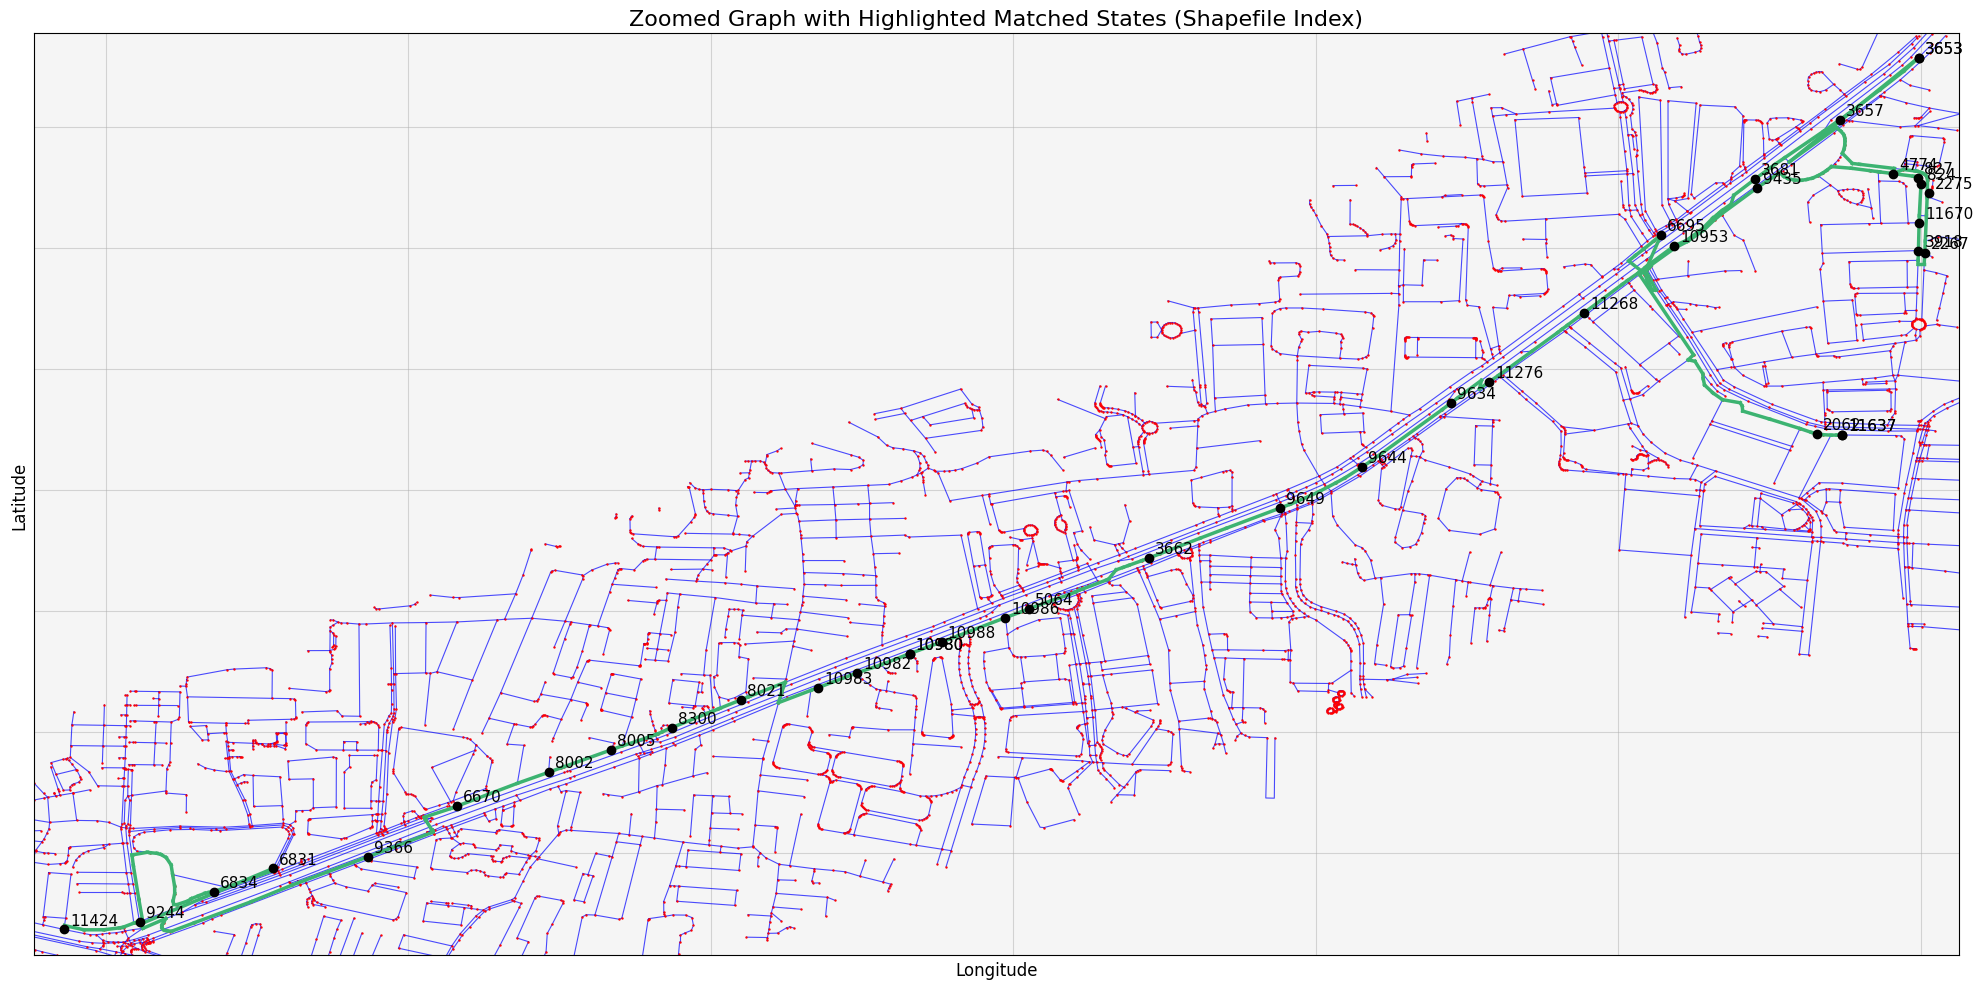

In [77]:
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
from geopy.distance import geodesic

fp = "/Users/ashwin/Desktop/IIIT/OSM version - within 500m of the path/For_Route_g1_i79_500m.shp"
data = gpd.read_file(fp)

G = nx.Graph()
coord_to_index = {}

for idx, line in enumerate(data.geometry):
    if line.geom_type == 'LineString':
        start, end = Point(line.coords[0]), Point(line.coords[-1])
        start_coord = tuple(start.coords[0])
        end_coord = tuple(end.coords[-1])
        G.add_node(start_coord, pos=start_coord)
        G.add_node(end_coord, pos=end_coord)
        G.add_edge(start_coord, end_coord, geometry=line)
        coord_to_index[start_coord] = idx
        coord_to_index[end_coord] = idx

pos = nx.get_node_attributes(G, 'pos')

valid_highlighted_nodes_3 = [tuple(coord) for coord in matched_coordinates_3 if tuple(coord) in pos]
valid_highlighted_nodes_3 = [node for node in valid_highlighted_nodes_3 if node in pos]

def geodesic_distance(a, b):
    return geodesic(a, b).meters

def find_shortest_path_between_nodes(G, start_node, end_node):
    return nx.shortest_path(G, source=start_node, target=end_node, weight=lambda u, v, d: geodesic_distance(pos[u], pos[v]))

def create_path_from_highlighted_nodes(G, nodes):
    path = [nodes[0]]
    visited = set(path)
    for i in range(len(nodes) - 1):
        segment = find_shortest_path_between_nodes(G, nodes[i], nodes[i + 1])
        for node in segment[1:]:
            if node not in visited:
                path.append(node)
                visited.add(node)
    return path

def calculate_path_segment_distances(G, nodes):
    segment_distances = []
    total_path_length = 0
    print("\n--- Path Segment Distances (Shortest Path Between Consecutive Matched States) ---")
    for i in range(len(nodes) - 1):
        segment = find_shortest_path_between_nodes(G, nodes[i], nodes[i + 1])
        distance = 0
        for j in range(len(segment) - 1):
            pt1 = segment[j]
            pt2 = segment[j + 1]
            distance += geodesic(pos[pt1], pos[pt2]).meters
        segment_distances.append(distance)
        total_path_length += distance
        print(f"Segment from state {coord_to_index[nodes[i]]} to {coord_to_index[nodes[i+1]]}: {distance:.2f} meters")
    print(f"\nTotal path length over shortest paths: {total_path_length:.2f} meters")
    return segment_distances, total_path_length

if len(valid_highlighted_nodes_3) > 2:
    path_nodes_3 = create_path_from_highlighted_nodes(G, valid_highlighted_nodes_3)
else:
    path_nodes_3 = valid_highlighted_nodes_3

segment_distances, total_path_length = calculate_path_segment_distances(G, valid_highlighted_nodes_3)

fig, ax = plt.subplots(figsize=(20, 10))

for edge in G.edges(data=True):
    line = edge[2]['geometry']
    x, y = line.xy
    ax.plot(x, y, color='blue', linewidth=0.8, alpha=0.7)

nx.draw_networkx_nodes(G, pos, ax=ax, node_size=0.5, node_color='red')

for node in valid_highlighted_nodes_3:
    x, y = node
    ax.plot(x, y, marker='o', color='black', markersize=6, zorder=3)
    idx_label = coord_to_index.get(node, 'N/A')
    ax.text(x + 0.0001, y + 0.0001, str(idx_label), fontsize=11, color='black', zorder=4)

for i in range(len(path_nodes_3) - 1):
    start = path_nodes_3[i]
    end = path_nodes_3[i + 1]
    line = LineString([Point(start), Point(end)])
    x, y = line.xy
    ax.plot(x, y, color='mediumseagreen', linewidth=2.5, linestyle='-', zorder=2)

x_coords = [coord[0] for coord in path_nodes_3]
y_coords = [coord[1] for coord in path_nodes_3]
margin = 0.0005
ax.set_xlim(min(x_coords) - margin, max(x_coords) + margin)
ax.set_ylim(min(y_coords) - margin, max(y_coords) + margin)
ax.set_facecolor('whitesmoke')
ax.tick_params(axis='both', which='major', labelsize=10)
plt.title("Zoomed Graph with Highlighted Matched States (Shapefile Index)", fontsize=16)
plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)
plt.grid(True, linestyle='-', alpha=0.5)
plt.tight_layout()
plt.show()


+---------------+------------+-----------------+
|   Path Length |   Geodesic |   distance_diff |
+===============+============+=================+
|      141.037  |   152.682  |       11.6444   |
+---------------+------------+-----------------+
|      213.356  |   145.212  |       68.1449   |
+---------------+------------+-----------------+
|      110.442  |   106.381  |        4.06053  |
+---------------+------------+-----------------+
|      685.029  |   173.491  |      511.537    |
+---------------+------------+-----------------+
|      201.162  |   182.069  |       19.0934   |
+---------------+------------+-----------------+
|      170.254  |   132.029  |       38.2246   |
+---------------+------------+-----------------+
|      116.381  |   119.081  |        2.7005   |
+---------------+------------+-----------------+
|      112.388  |   129.653  |       17.2657   |
+---------------+------------+-----------------+
|      127.544  |   132.893  |        5.34917  |
+---------------+---

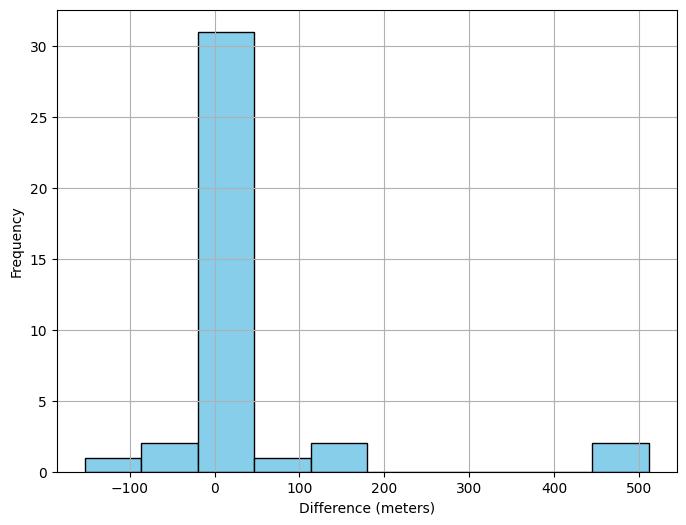

In [78]:
from geopy.distance import geodesic
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

distances_3_3 = []
distances_3 = []
highlighted_distances = []
total_distance = 0

def calculate_consecutive_geodesic_distances(points, distances_list):
    total = 0
    for i in range(1, len(points)):
        distance = geodesic(points[i-1], points[i]).meters
        total += distance
        distances_list.append(distance)
    return distances_list, total

consecutive_distances_km_3, total_distance = calculate_consecutive_geodesic_distances(path_nodes_3, distances_3)

valid_highlighted_indices = [path_nodes_3.index(node) for node in valid_highlighted_nodes_3 if node in path_nodes_3]

for i in range(1, len(valid_highlighted_indices)):
    start_index, end_index = valid_highlighted_indices[i-1], valid_highlighted_indices[i]
    highlighted_distance = np.sum(distances_3[start_index:end_index])
    highlighted_distances.append(highlighted_distance)

consecutive_distances_km_3, _ = calculate_consecutive_geodesic_distances(observations_3_no_duplicates, distances_3_3)

data = []
for i in range(max(len(highlighted_distances), len(distances_3_3))):
    row = [
        highlighted_distances[i] if i < len(highlighted_distances) else "", 
        distances_3_3[i] if i < len(distances_3_3) else "", 
        abs(highlighted_distances[i] - distances_3_3[i]) if i < len(highlighted_distances) and i < len(distances_3_3) else ""
    ]
    data.append(row)

headers = ["Path Length", "Geodesic", "distance_diff"]
print(tabulate(data, headers=headers, tablefmt="grid"))

if len(highlighted_distances) == len(distances_3_3):
    plt.figure(figsize=(8, 6))
    plt.hist(np.array(highlighted_distances) - np.array(distances_3_3), bins=10, edgecolor='black', color='skyblue')
    plt.xlabel("Difference (meters)")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()
else:
    print("\nThe highlighted_distances and distances_3_3 arrays have different lengths. Cannot compute differences.")


In [79]:
from tabulate import tabulate
data = []
max_len = min(len(highlighted_distances), len(distances_3_3))
for i in range(max_len):
    path_length = highlighted_distances[i]
    geodesic = distances_3_3[i]
    distance_diff = abs(path_length - geodesic)

    if distance_diff > 100:
        data.append([i, path_length, geodesic, distance_diff])

print(tabulate(data, headers=["Index", "Path Length (m)", "Geodesic (m)", "Distance Diff (m)"], tablefmt="grid"))

significant_indices = [row[0] for row in data]
print("\nIndices with distance_diff > 100:")
print(significant_indices)

+---------+-------------------+----------------+---------------------+
|   Index |   Path Length (m) |   Geodesic (m) |   Distance Diff (m) |
+=========+===================+================+=====================+
|       3 |           685.029 |       173.491  |             511.537 |
+---------+-------------------+----------------+---------------------+
|      26 |             0     |       152.651  |             152.651 |
+---------+-------------------+----------------+---------------------+
|      27 |           607.721 |        98.7189 |             509.002 |
+---------+-------------------+----------------+---------------------+
|      35 |           346.694 |       190.594  |             156.099 |
+---------+-------------------+----------------+---------------------+
|      36 |           408.349 |       278.448  |             129.902 |
+---------+-------------------+----------------+---------------------+

Indices with distance_diff > 100:
[3, 26, 27, 35, 36]


Total distance of the shortest path: 6032.57 meters
Total geodesic distance : 4723.31 meters

Observation to Matched Node Mapping (within Geofence):
  Obs Index  Obs Coord (lon, lat)      Matched Node Coord          Shapefile Index
-----------  ------------------------  ------------------------  -----------------
          0  (77.6641874, 12.9209461)  (77.6643062, 12.9209196)              11424
          1  (77.6655549, 12.9210216)  (77.6655579, 12.9210809)               9244
          2  (77.6668509, 12.9215377)  (77.6667812, 12.9216991)               6834
          3  (77.6677983, 12.922015)   (77.6677634, 12.9221797)               6831
          4  (77.6693455, 12.9226942)  (77.6693352, 12.9224217)               9366
          5  (77.6709688, 12.9234264)  (77.670801, 12.9234653)                6670
          6  (77.6721467, 12.92392)    (77.6723186, 12.9241671)               8002
          7  (77.6732089, 12.9243746)  (77.6733563, 12.924632)                8005
          8  (77.6743

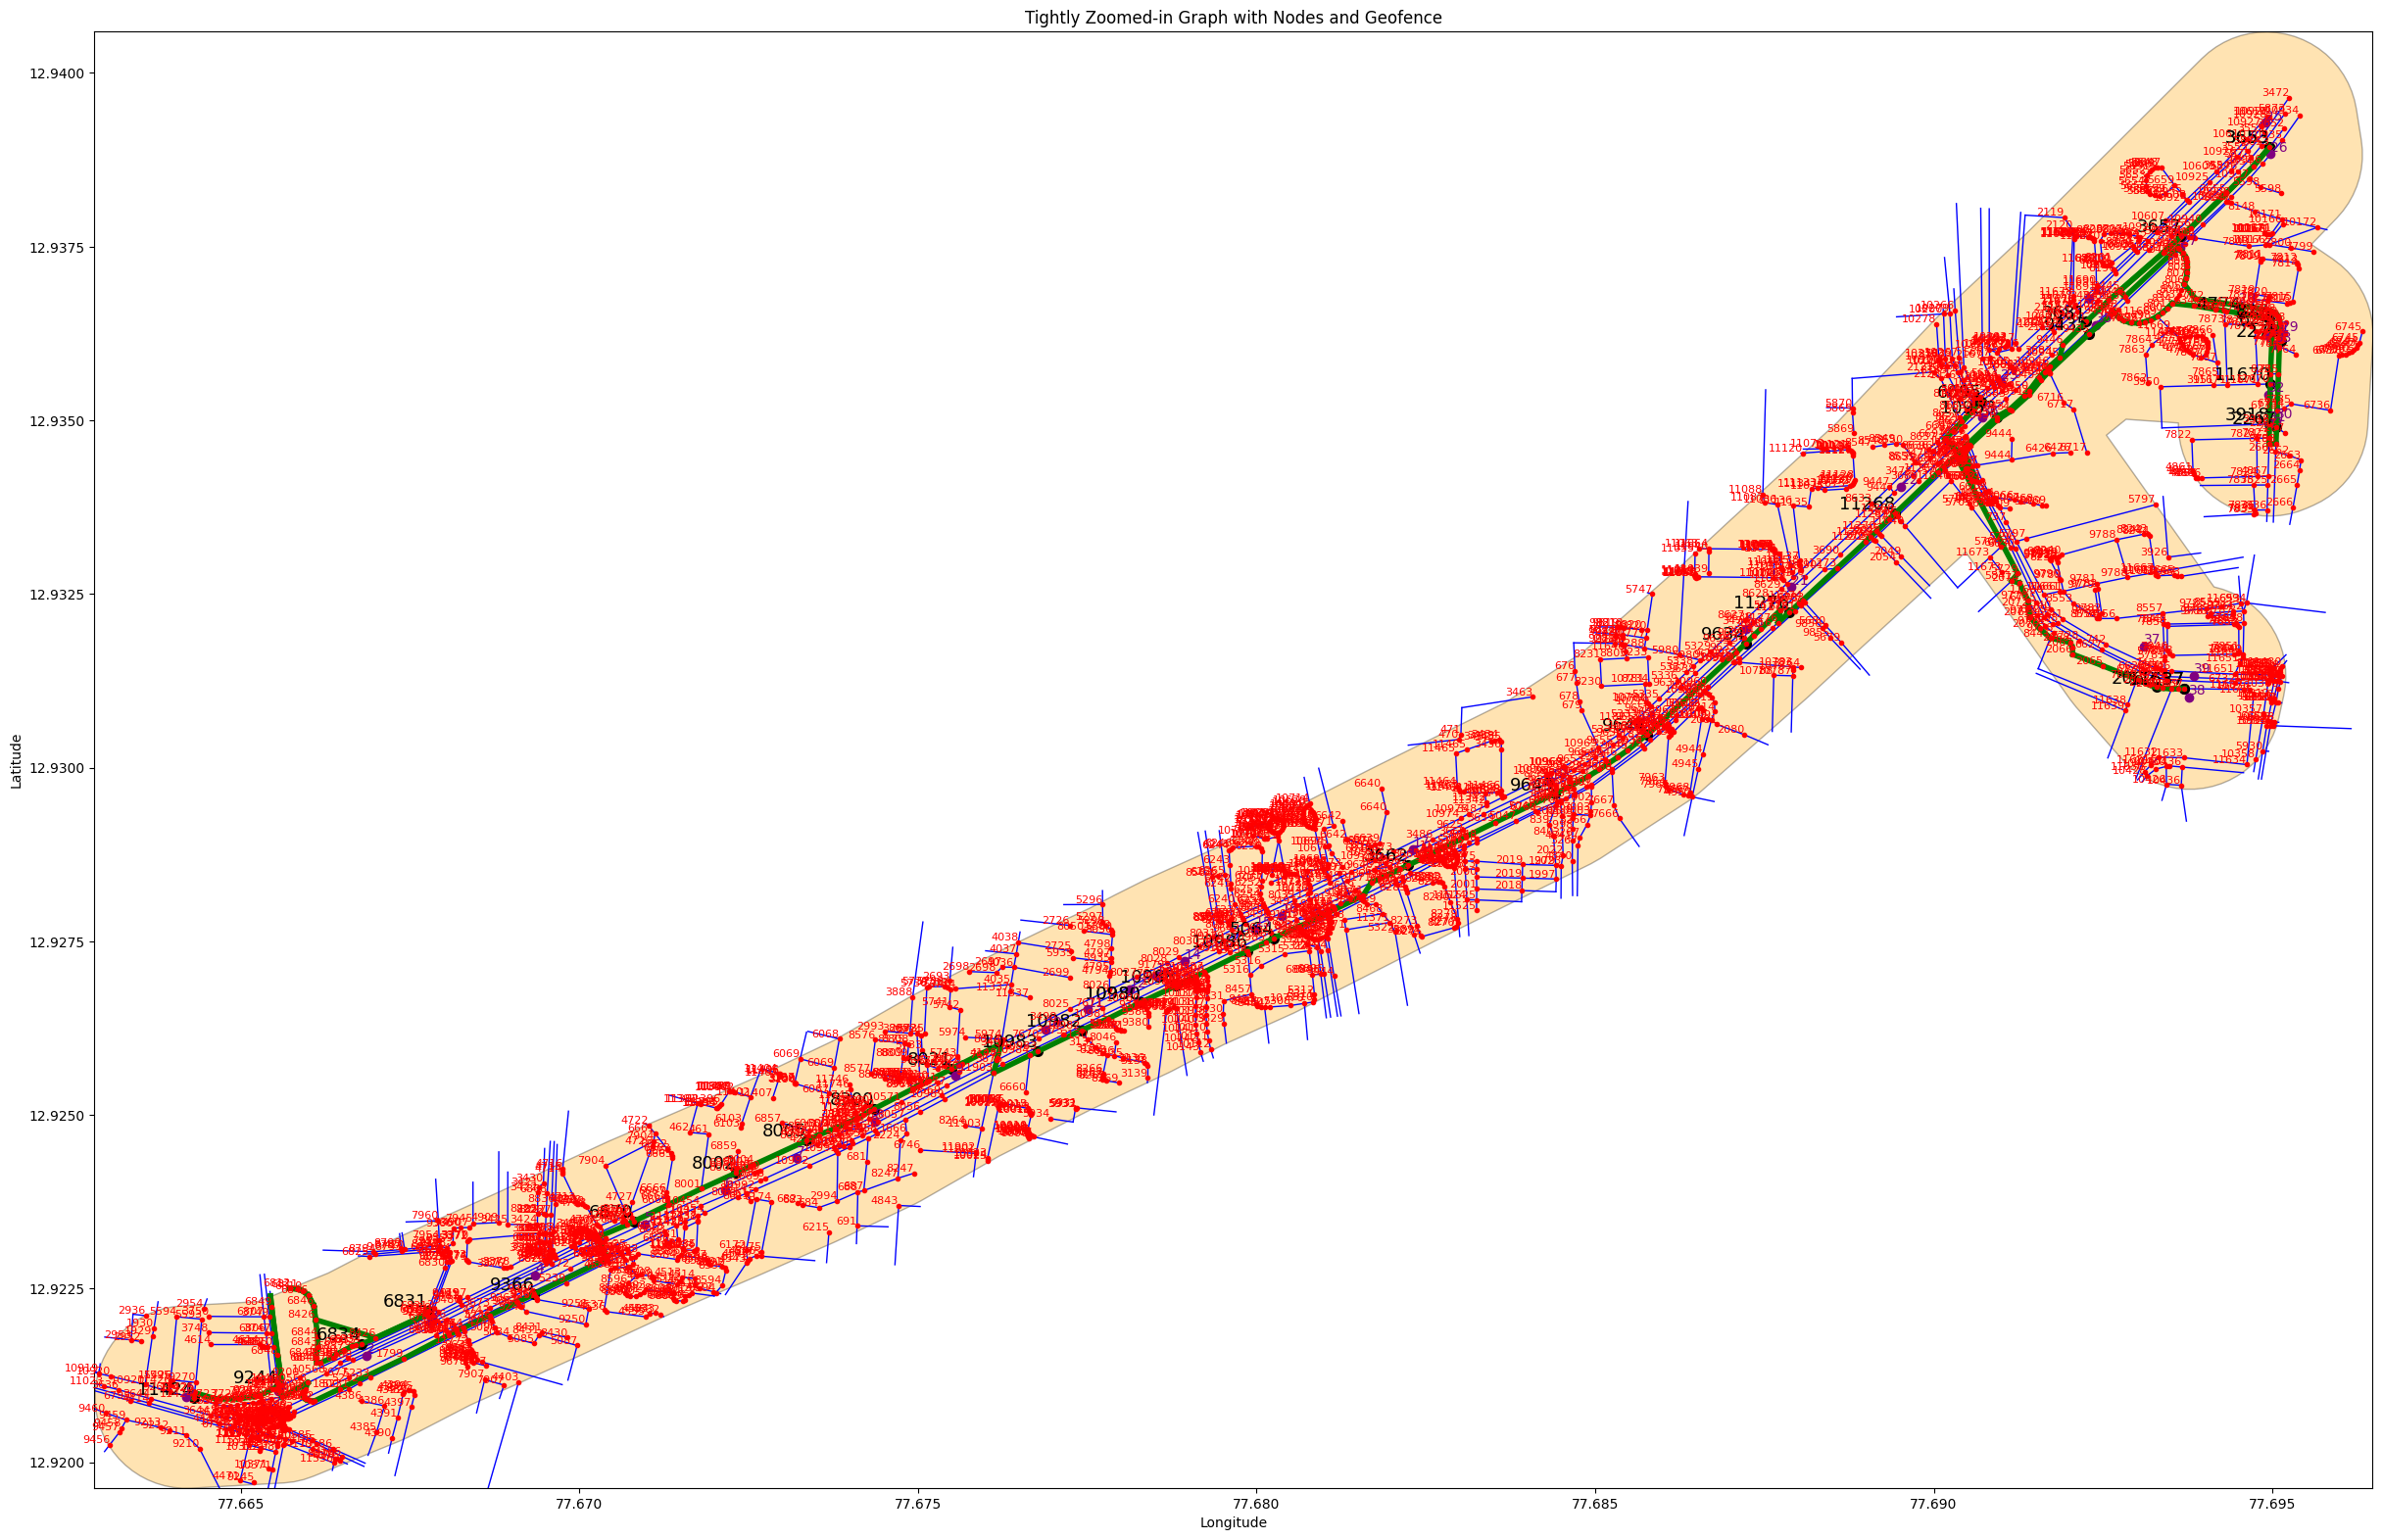

In [80]:
import networkx as nx
import matplotlib.pyplot as plt
import gpxpy
import geopandas as gpd
from shapely.geometry import LineString, Point
from geopy.distance import geodesic
from tabulate import tabulate

fp = "/Users/ashwin/Desktop/IIIT/OSM version - within 500m of the path/For_Route_g1_i79_500m.shp"
gpx_file_path = '/Users/ashwin/Desktop/IIIT/fefa3de2-c689-4017-a629-baf7e68f5d69_493.gpx'

data = gpd.read_file(fp)
G = nx.Graph()
coord_to_index = {}

for idx, line in enumerate(data.geometry):
    if line.geom_type == 'LineString':
        start, end = Point(line.coords[0]), Point(line.coords[-1])
        start_coord = tuple(start.coords[0])
        end_coord = tuple(end.coords[-1])
        G.add_node(start_coord, pos=start_coord)
        G.add_node(end_coord, pos=end_coord)
        G.add_edge(start_coord, end_coord, geometry=line)
        coord_to_index[start_coord] = idx
        coord_to_index[end_coord] = idx

with open(gpx_file_path, 'r') as gpx_file:
    gpx = gpxpy.parse(gpx_file)

start_index_3_3 = 219
end_index_3_3 = 268

observations_3 = [
    (point.longitude, point.latitude)
    for track in gpx.tracks
    for segment in track.segments
    for i, point in enumerate(segment.points)
    if start_index_3_3 <= i < end_index_3_3
]

observations_3_no_duplicates = [pt for i, pt in enumerate(observations_3) if i == 0 or pt != observations_3[i - 1]]

gpx_path = LineString(observations_3_no_duplicates)
gpx_gdf = gpd.GeoDataFrame(geometry=[gpx_path], crs="EPSG:4326").to_crs(epsg=3857)
geofence = gpx_gdf.buffer(150).to_crs(epsg=4326)

connected_components = sorted(nx.connected_components(G), key=len, reverse=True)

if connected_components:
    subgraph_3 = G.subgraph(connected_components[0]).copy()
    pos_3 = nx.get_node_attributes(subgraph_3, 'pos')

    nodes_in_geofence = [node for node, position in pos_3.items() if geofence.geometry[0].contains(Point(position))]
    edges_in_geofence = [edge for edge in subgraph_3.edges(data=True) if geofence.geometry[0].intersects(edge[2]['geometry'])]

    def geodesic_distance(a, b):
        return geodesic(a, b).kilometers

    def shortest_path_geodesic_weight(G, source, target):
        return nx.shortest_path(G, source=source, target=target, weight=lambda u, v, d: geodesic_distance(pos_3[u], pos_3[v]))

    fig, ax = plt.subplots(figsize=(30, 30))

    for edge in edges_in_geofence:
        line = edge[2]['geometry']
        x, y = line.xy
        ax.plot(x, y, color='blue', linewidth=1)

    valid_highlighted_nodes_3 = [tuple(coord) for coord in matched_coordinates_3 if tuple(coord) in pos_3]
    valid_nodes_in_geofence = [node for node in valid_highlighted_nodes_3 if Point(pos_3[node]).within(geofence.geometry[0])]

    for idx, node in enumerate(valid_nodes_in_geofence):
        x, y = node
        ax.plot(x, y, marker='o', color='black', markersize=7)
        node_index = coord_to_index.get((x, y), None)
        ax.text(x, y, str(node_index), fontsize=13, color='black', ha='right', va='bottom')

    for i, pt in enumerate(observations_3_no_duplicates):
        obs_point = Point(pt)
        if geofence.geometry[0].contains(obs_point):
            ax.plot(pt[0], pt[1], marker='o', color='purple', markersize=6)
            ax.text(pt[0], pt[1], str(i), fontsize=10, color='purple', ha='left', va='bottom')

    geofence.plot(ax=ax, color='orange', alpha=0.3, edgecolor='black')

    plotted_edges = set()
    total_shortest_path_distance = 0.0
    for i in range(len(valid_nodes_in_geofence) - 1):
        start = valid_nodes_in_geofence[i]
        end = valid_nodes_in_geofence[i + 1]
        if nx.has_path(subgraph_3, start, end):
            path = shortest_path_geodesic_weight(subgraph_3, start, end)
            segment_distance = 0.0
            for j in range(len(path) - 1):
                node_start = path[j]
                node_end = path[j + 1]
                dist = geodesic_distance(pos_3[node_start], pos_3[node_end])
                segment_distance += dist
                if (node_start, node_end) not in plotted_edges:
                    line = subgraph_3[node_start][node_end]['geometry']
                    if geofence.geometry[0].intersects(line):
                        intersected_line = line.intersection(geofence.geometry[0])
                        if isinstance(intersected_line, LineString):
                            x, y = intersected_line.xy
                            ax.plot(x, y, color='green', linewidth=4, linestyle='-')
                            plotted_edges.add((node_start, node_end))
            total_shortest_path_distance += segment_distance

    def calculate_geodesic_distance(points):
        total_distance = 0.0
        for i in range(1, len(points)):
            total_distance += geodesic(points[i - 1], points[i]).kilometers
        return total_distance

    total_observation_path_distance = calculate_geodesic_distance(observations_3_no_duplicates)
    print(f"Total distance of the shortest path: {total_shortest_path_distance * 1000:.2f} meters")
    print(f"Total geodesic distance : {total_observation_path_distance * 1000:.2f} meters")

    for node in nodes_in_geofence:
        x, y = pos_3[node]
        ax.plot(x, y, marker='o', color='red', markersize=3)
        node_index = coord_to_index.get((x, y), None)
        ax.text(x, y, str(node_index), fontsize=8, color='red', ha='right', va='bottom')

    mapping_table = []
    obs_counter = 0
    for i, pt in enumerate(observations_3_no_duplicates):
        obs_point = Point(pt)
        if geofence.geometry[0].contains(obs_point):
            if obs_counter < len(valid_nodes_in_geofence):
                matched_node = valid_nodes_in_geofence[obs_counter]
                matched_index = coord_to_index.get(matched_node, "N/A")
                mapping_table.append([i, pt, matched_node, matched_index])
                obs_counter += 1

    print("\nObservation to Matched Node Mapping (within Geofence):")
    print(tabulate(mapping_table, headers=["Obs Index", "Obs Coord (lon, lat)", "Matched Node Coord", "Shapefile Index"]))

    zoom_factor = 0.000001
    minx, miny, maxx, maxy = geofence.total_bounds
    ax.set_xlim(minx - zoom_factor, maxx + zoom_factor)
    ax.set_ylim(miny - zoom_factor, maxy + zoom_factor)
    plt.title("Tightly Zoomed-in Graph with Nodes and Geofence")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()


Candidate idx: 1046, Angle Difference: 1.44°, Distance Difference: 0.0101 km
Candidate idx: 9244, Angle Difference: 0.90°, Distance Difference: 0.0116 km
Candidate idx: 4092, Angle Difference: 0.93°, Distance Difference: 0.0481 km
Candidate idx: 1802, Angle Difference: 1.04°, Distance Difference: 0.0445 km
Candidate idx: 1803, Angle Difference: 2.21°, Distance Difference: 0.0136 km

Top 5 candidate node numbers for observation 1: [4097, 9242, 4096, 7725, 9242]
Reassigned: original 9244 → new index: 4097, angle: 0.09°, dist: 43.33 m
Candidate idx: 1799, Angle Difference: 0.94°, Distance Difference: 0.0225 km
Candidate idx: 5231, Angle Difference: 4.27°, Distance Difference: 0.0181 km
Candidate idx: 5232, Angle Difference: 3.12°, Distance Difference: 0.0348 km
Candidate idx: 5233, Angle Difference: 2.42°, Distance Difference: 0.0528 km
Candidate idx: 6788, Angle Difference: 2.90°, Distance Difference: 0.0633 km

Top 5 candidate node numbers for observation 2: [1799, 5233, 6788, 5232, 523

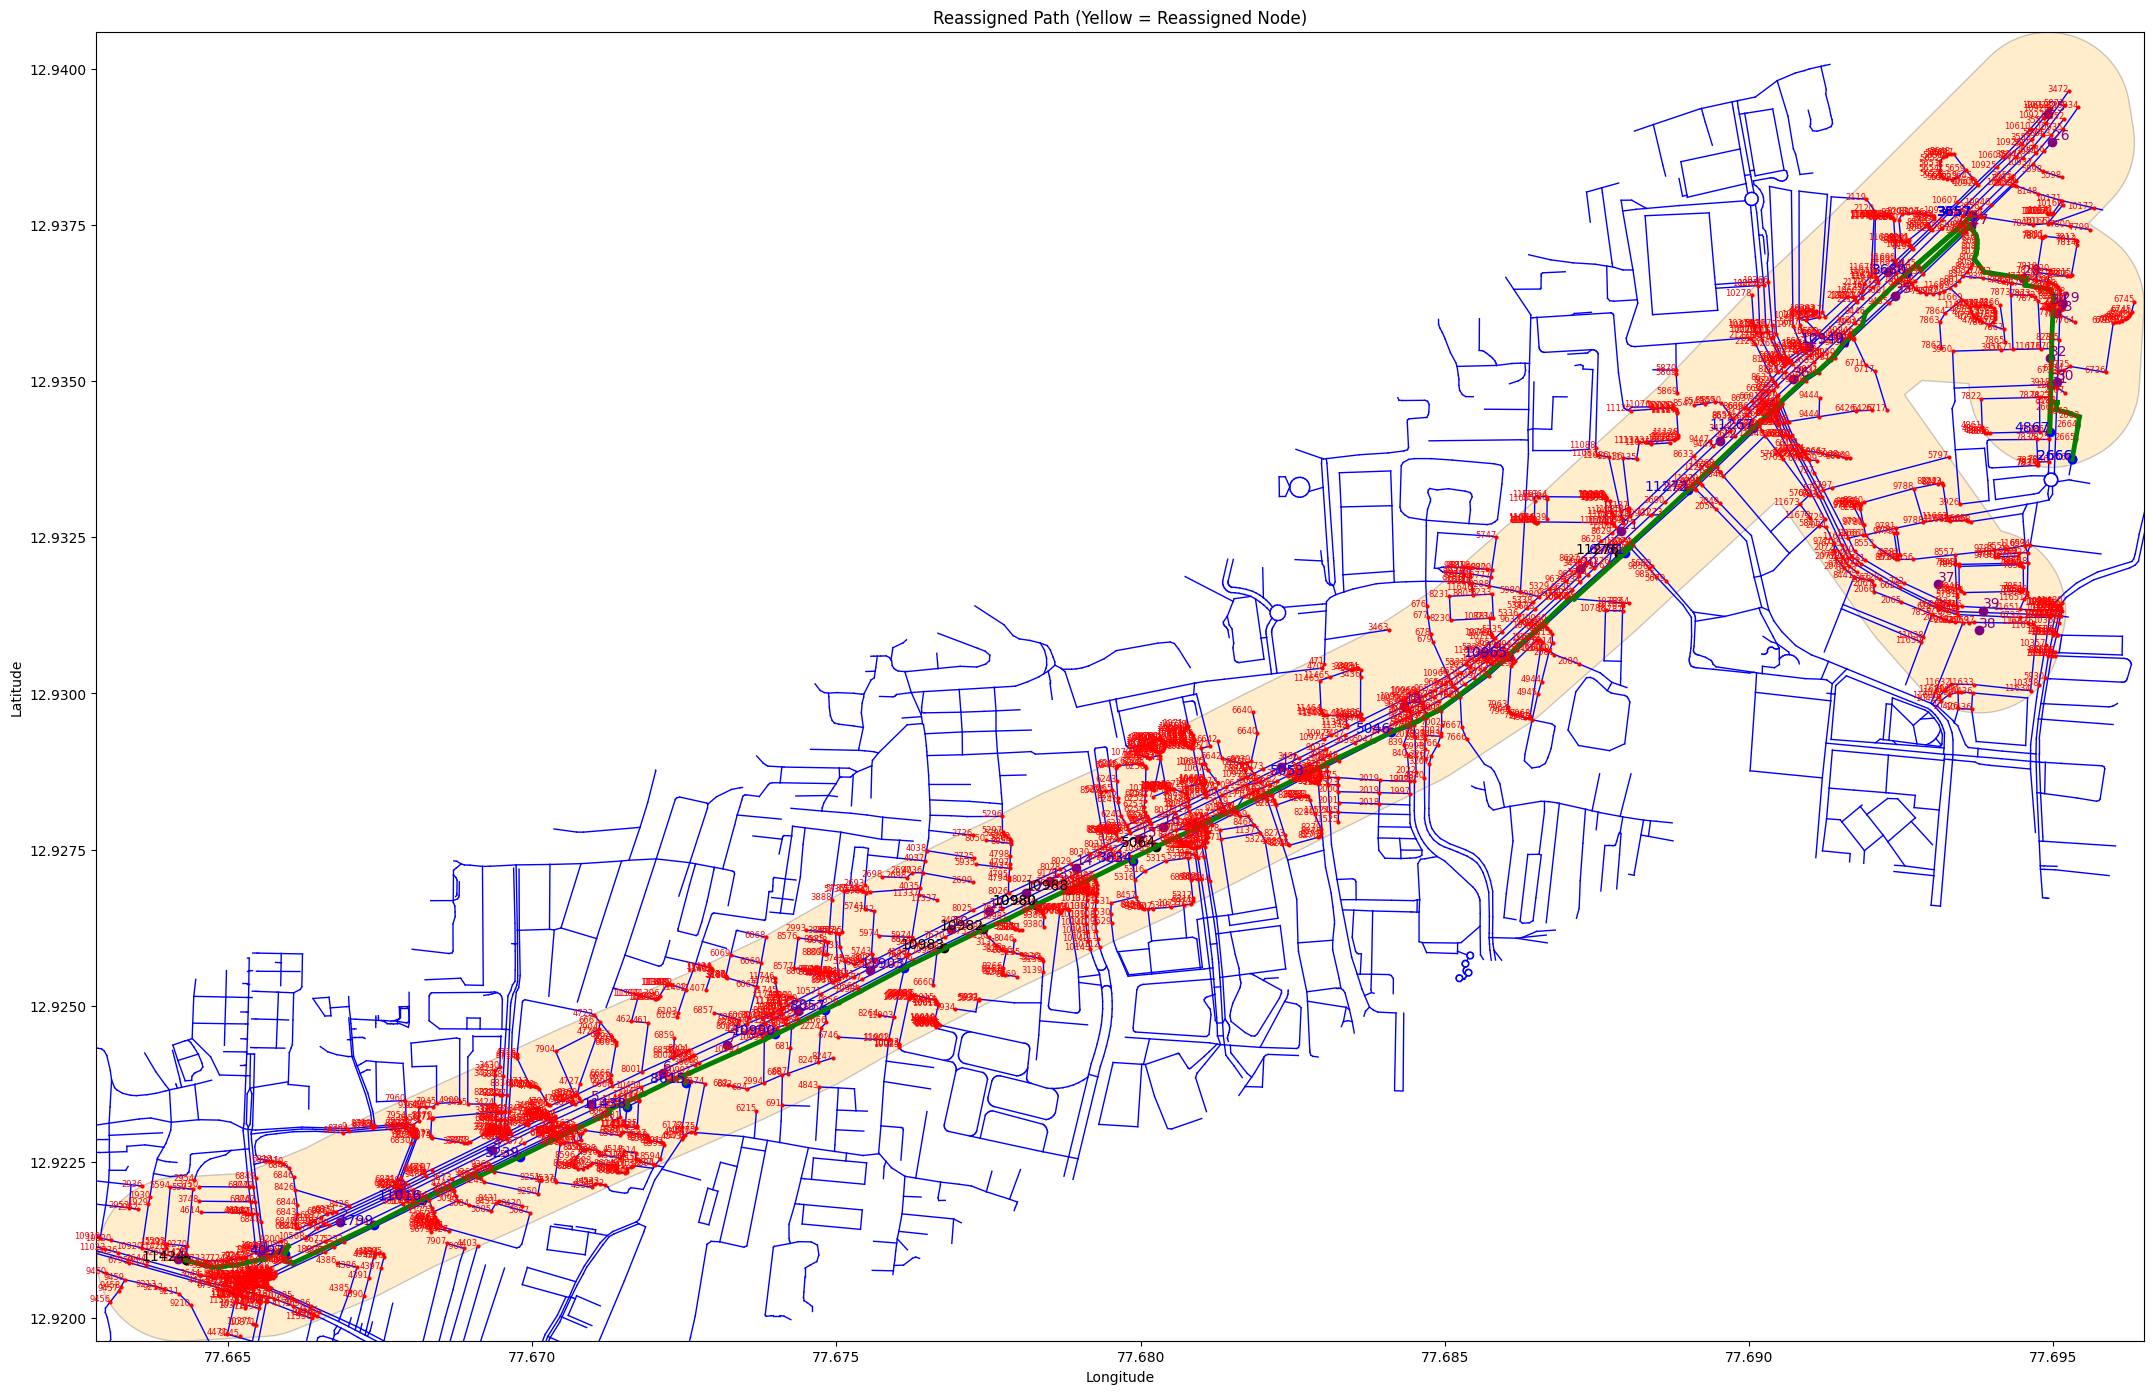

In [81]:
import networkx as nx
import matplotlib.pyplot as plt
import gpxpy
import geopandas as gpd
from shapely.geometry import LineString, Point
from geopy.distance import geodesic
import math
import numpy as np

fp = "/Users/ashwin/Desktop/IIIT/OSM version - within 500m of the path/For_Route_g1_i79_500m.shp"
gpx_file_path = '/Users/ashwin/Desktop/IIIT/fefa3de2-c689-4017-a629-baf7e68f5d69_493.gpx'

data = gpd.read_file(fp)
G = nx.Graph()
coord_to_index = {}

for idx, line in enumerate(data.geometry):
    if line.geom_type == 'LineString':
        start, end = Point(line.coords[0]), Point(line.coords[-1])
        start_coord = tuple(start.coords[0])
        end_coord = tuple(end.coords[-1])
        G.add_node(start_coord, pos=start_coord)
        G.add_node(end_coord, pos=end_coord)
        G.add_edge(start_coord, end_coord, geometry=line)
        coord_to_index[start_coord] = idx
        coord_to_index[end_coord] = idx

with open(gpx_file_path, 'r') as gpx_file:
    gpx = gpxpy.parse(gpx_file)

start_index = 219
end_index = 268

observations_3 = [
    (point.longitude, point.latitude)
    for track in gpx.tracks
    for segment in track.segments
    for i, point in enumerate(segment.points)
    if start_index <= i < end_index
]

observations_3_no_duplicates = [pt for i, pt in enumerate(observations_3) if i == 0 or pt != observations_3[i - 1]]

gpx_path = LineString(observations_3_no_duplicates)
gpx_gdf = gpd.GeoDataFrame(geometry=[gpx_path], crs="EPSG:4326")
gpx_gdf_3857 = gpx_gdf.to_crs(epsg=3857)
geofence_buffered_3857 = gpx_gdf_3857.buffer(150)  
geofence = geofence_buffered_3857.to_crs(epsg=4326)  

connected_components = sorted(nx.connected_components(G), key=len, reverse=True)

if connected_components:
    subgraph = G.subgraph(connected_components[0]).copy()
    pos = nx.get_node_attributes(subgraph, 'pos')
    states_in_geofence_3 = [node for node in pos if geofence.geometry[0].contains(Point(pos[node]))]

    def geodesic_distance(a, b):
        return geodesic(a, b).kilometers

    def shortest_path_distance(G, source, target):
        path = nx.shortest_path(G, source, target, weight=lambda u, v, d: geodesic_distance(pos[u], pos[v]))
        return path, sum(geodesic_distance(pos[path[i]], pos[path[i + 1]]) for i in range(len(path) - 1))

    def calculate_heading(p1, p2):
        lat1, lon1 = map(math.radians, p1)
        lat2, lon2 = map(math.radians, p2)
        d_lon = lon2 - lon1
        x = math.sin(d_lon) * math.cos(lat2)
        y = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(d_lon)
        return (math.degrees(math.atan2(x, y)) + 360) % 360

    def angle_diff_signed(a, b):
        diff = (b - a + 360) % 360
        return diff - 360 if diff > 180 else diff

    def reassign_node(fixed_node, obs_heading, i):
        candidates = []
        obs_dist = geodesic(observations_3_no_duplicates[i - 1], observations_3_no_duplicates[i]).km
        for candidate in states_in_geofence_3:
            if not nx.has_path(subgraph, fixed_node, candidate):
                continue
            node_heading = calculate_heading(pos[fixed_node], pos[candidate])
            angle_difference = abs(angle_diff_signed(obs_heading, node_heading))
            _, dist_to_candidate = shortest_path_distance(subgraph, fixed_node, candidate)
            dist_difference = abs(dist_to_candidate - obs_dist)
            if angle_difference <= 5 and dist_difference <= 0.07:  
                candidates.append((angle_difference, dist_difference, candidate))
        for cand in candidates[:5]:
            print(f"Candidate idx: {coord_to_index.get(cand[2], 'N/A')}, Angle Difference: {cand[0]:.2f}°, Distance Difference: {cand[1]:.4f} km")
        if candidates:
            candidates.sort(key=lambda x: (x[0], x[1]))
            print(f"\nTop 5 candidate node numbers for observation {i}: {[coord_to_index.get(c[2], 'N/A') for c in candidates[:5]]}")
            best_candidate = candidates[0]
            return best_candidate[2], best_candidate  
        return None, None

    reassigned_nodes = [tuple(matched_coordinates_3[0])]
    reassigned_log = []
    reassignment_memory = {}

    for i in range(1, min(len(matched_coordinates_3), len(observations_3_no_duplicates))):
        fixed_node = reassigned_nodes[-1]
        target_node = tuple(matched_coordinates_3[i])
        original_index = coord_to_index.get(target_node, None)

        if original_index in reassignment_memory:
            reassigned = reassignment_memory[original_index]
            reassigned_nodes.append(reassigned)
            continue

        if fixed_node in pos and target_node in pos and nx.has_path(subgraph, fixed_node, target_node):
            _, dist = shortest_path_distance(subgraph, fixed_node, target_node)
            if dist <= 0.1:
                reassigned_nodes.append(target_node)
                continue

        obs_heading = calculate_heading(observations_3_no_duplicates[i - 1], observations_3_no_duplicates[i])
        reassigned, candidate_info = reassign_node(fixed_node, obs_heading, i)
        if reassigned:
            reassigned_nodes.append(reassigned)
            idx = coord_to_index.get(reassigned, "N/A")
            reassignment_memory[original_index] = reassigned
            print(f"Reassigned: original {original_index} → new index: {idx}, angle: {candidate_info[0]:.2f}°, dist: {candidate_info[1]*1000:.2f} m")
            reassigned_log.append((target_node, reassigned, idx, candidate_info))
        else:
            # fallback_node = fixed_node
            # best_angle_diff = float('inf')

            # for neighbor in subgraph.neighbors(fixed_node):
            #     if not nx.has_path(subgraph, fixed_node, neighbor):
            #         continue
            #     node_heading = calculate_heading(pos[fixed_node], pos[neighbor])
            #     angle_difference = abs(angle_diff_signed(obs_heading, node_heading))
            #     if angle_difference < best_angle_diff:
            #         best_angle_diff = angle_difference
            #         fallback_node = neighbor
            # reassigned_nodes.append(fallback_node)
            # idx = coord_to_index.get(fallback_node, "N/A")
            # print(f"[OBS {i}] Fallback to neighbor: index {idx}, Node {fallback_node}, angle_diff: {best_angle_diff:.2f}°")
            reassigned_nodes.append(fixed_node)
            idx = coord_to_index.get(fixed_node, "N/A")
            print(f"[OBS {i}] Retained (fallback): index {idx}, Node {fixed_node}, Obs {observations_3_no_duplicates[i]}")

    fig, ax = plt.subplots(figsize=(35, 17))

    for edge in subgraph.edges(data=True):
        line = edge[2]['geometry']
        x, y = line.xy
        ax.plot(x, y, color='blue', linewidth=1)

    for node in states_in_geofence_3:
        x, y = pos[node]
        ax.plot(x, y, marker='o', color='red', markersize=2)
        idx = coord_to_index.get((x, y), None)
        if idx is not None:
            ax.text(x, y, str(idx), fontsize=6, color='red', ha='right')

    for node in reassigned_nodes:
        if node in pos and geofence.geometry[0].contains(Point(pos[node])):
            x, y = node
            color = 'blue' if any(node == r[1] for r in reassigned_log) else 'black'
            ax.plot(x, y, marker='o', color=color, markersize=6)
            idx = coord_to_index.get((x, y), None)
            if idx is not None:
                ax.text(x, y, str(idx), fontsize=10, color=color, ha='right')

    for i, pt in enumerate(observations_3_no_duplicates):
        obs_point = Point(pt)
        if geofence.geometry[0].contains(obs_point):
            ax.plot(pt[0], pt[1], marker='o', color='purple', markersize=6)
            ax.text(pt[0], pt[1], str(i), fontsize=10, color='purple', ha='left', va='bottom')

    plotted_edges = set()
    print("--Segment Distances--")
    for i in range(1, len(reassigned_nodes)):
        a, b = reassigned_nodes[i - 1], reassigned_nodes[i]
        if a in pos and b in pos and nx.has_path(subgraph, a, b):
            path, d = shortest_path_distance(subgraph, a, b)
            print(f"Segment {i}: {d*1000:.2f} m")
            for j in range(len(path) - 1):
                edge_geom = subgraph[path[j]][path[j + 1]]['geometry']
                if (path[j], path[j + 1]) not in plotted_edges:
                    x, y = edge_geom.xy
                    ax.plot(x, y, color='green', linewidth=3.5)
                    plotted_edges.add((path[j], path[j + 1]))

    geofence.plot(ax=ax, color='orange', alpha=0.2, edgecolor='black')
    minx, miny, maxx, maxy = geofence.total_bounds
    ax.set_xlim(minx - 1e-6, maxx + 1e-6)
    ax.set_ylim(miny - 1e-6, maxy + 1e-6)
    plt.title("Reassigned Path (Yellow = Reassigned Node)")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

In [84]:
from tabulate import tabulate
mapping_table = []
for i, (obs_coord, reassigned_node) in enumerate(zip(observations_3_no_duplicates, reassigned_nodes)):
    if reassigned_node in coord_to_index:
        node_index = coord_to_index[reassigned_node]
    else:
        node_index = "N/A"
    mapping_table.append([i, obs_coord, reassigned_node, node_index])

print("\nObservation to Reassigned Node Mapping Table:")
print(tabulate(mapping_table, headers=["Obs Index", "Obs Coord (lon, lat)", "Reassigned Node", "Shapefile Index"]))



Observation to Reassigned Node Mapping Table:
  Obs Index  Obs Coord (lon, lat)      Reassigned Node             Shapefile Index
-----------  ------------------------  ------------------------  -----------------
          0  (77.6641874, 12.9209461)  (77.6643062, 12.9209196)              11424
          1  (77.6655549, 12.9210216)  (77.6659322, 12.9210217)               4097
          2  (77.6668509, 12.9215377)  (77.6674062, 12.9214943)               1799
          3  (77.6677983, 12.922015)   (77.6681907, 12.9218887)              11016
          4  (77.6693455, 12.9226942)  (77.6698013, 12.9225832)               5239
          5  (77.6709688, 12.9234264)  (77.6715578, 12.9233779)              11438
          6  (77.6721467, 12.92392)    (77.672522, 12.9237667)                8615
          7  (77.6732089, 12.9243746)  (77.6739959, 12.9245395)              10990
          8  (77.6743646, 12.9249093)  (77.6748125, 12.9249327)               8057
          9  (77.6755466, 12.9255681)  (

In [85]:
from tabulate import tabulate
print("\n-- Detailed Segment Distance Comparison Table --")

table_data = []
header = [
    "Obs Index",
    "Matched Index",
    "Reassigned Index",
    "Geodesic (m)",
    "Matched Path (m)",
    "Reassigned Path (m)",
    "|Matched - Geodesic| (m)",
    "|Reassigned - Geodesic| (m)"
]

total_geodesic = 0
total_matched_path = 0
total_reassigned_path = 0

for i in range(1, len(observations_3_no_duplicates)):
    obs1 = observations_3_no_duplicates[i - 1]
    obs2 = observations_3_no_duplicates[i]
    geod = geodesic(obs1, obs2).meters  

    matched1 = tuple(matched_coordinates_3[i - 1])
    matched2 = tuple(matched_coordinates_3[i])
    matched_path_len = 0
    if matched1 in pos and matched2 in pos and nx.has_path(subgraph, matched1, matched2):
        _, matched_path_len = shortest_path_distance(subgraph, matched1, matched2)
        matched_path_len *= 1000  

    reassigned1 = tuple(reassigned_nodes[i - 1])
    reassigned2 = tuple(reassigned_nodes[i])
    reassigned_path_len = 0
    if reassigned1 in pos and reassigned2 in pos and nx.has_path(subgraph, reassigned1, reassigned2):
        _, reassigned_path_len = shortest_path_distance(subgraph, reassigned1, reassigned2)
        reassigned_path_len *= 1000  

    total_geodesic += geod
    total_matched_path += matched_path_len
    total_reassigned_path += reassigned_path_len

    matched_idx = coord_to_index.get(matched2, "N/A")
    reassigned_idx = coord_to_index.get(reassigned2, "N/A")

    table_data.append([
        i,
        matched_idx,
        reassigned_idx,
        round(geod, 4),
        round(matched_path_len, 4),
        round(reassigned_path_len, 4),
        round(abs(matched_path_len - geod), 4),
        round(abs(reassigned_path_len - geod), 4)
    ])

print(tabulate(table_data, headers=header, tablefmt="rounded_grid"))

abs_error_matched = abs(total_matched_path - total_geodesic)
abs_error_reassigned = abs(total_reassigned_path - total_geodesic)
percent_error_matched = (abs_error_matched / total_geodesic) * 100
percent_error_reassigned = (abs_error_reassigned / total_geodesic) * 100

print("\n-- Total Distances and Errors --")
print(f"Total Geodesic Distance:           {round(total_geodesic, 4)} meters")
print(f"Total Matched Path Length:         {round(total_matched_path, 4)} meters")
print(f"Total Reassigned Path Length:      {round(total_reassigned_path, 4)} meters")
print(f"|Matched - Geodesic| Error:        {round(abs_error_matched, 4)} meters ({round(percent_error_matched, 2)}%)")
print(f"|Reassigned - Geodesic| Error:     {round(abs_error_reassigned, 4)} meters ({round(percent_error_reassigned, 2)}%)")



-- Detailed Segment Distance Comparison Table --
╭─────────────┬─────────────────┬────────────────────┬────────────────┬────────────────────┬───────────────────────┬────────────────────────────┬───────────────────────────────╮
│   Obs Index │   Matched Index │   Reassigned Index │   Geodesic (m) │   Matched Path (m) │   Reassigned Path (m) │   |Matched - Geodesic| (m) │   |Reassigned - Geodesic| (m) │
├─────────────┼─────────────────┼────────────────────┼────────────────┼────────────────────┼───────────────────────┼────────────────────────────┼───────────────────────────────┤
│           1 │            9244 │               4097 │       152.682  │           141.037  │              196.014  │                    11.6444 │                       43.3328 │
├─────────────┼─────────────────┼────────────────────┼────────────────┼────────────────────┼───────────────────────┼────────────────────────────┼───────────────────────────────┤
│           2 │            6834 │               1799 │      